In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [143]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [144]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1. Data Quality checking, handling missing values and Exploratory Data Analysis 

In [145]:
#1.understand the data using .info() and .describe()
#2.explore different features by plotting the distribution and understanding the relation with target variable
#3.handle missing values
#3.feature engineering
 #3.1cabin,ticket,name
 #3.2maybe age
#5.normalize
#6.scale

In [146]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [147]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Exploratory Data Analysis 

In [148]:
#let's differentiate the numerical and categorical to plot the distribution of the features
train_data_num = train_data[['Age','SibSp','Parch','Fare']]
train_data_cat = train_data[['Name','Age','Survived','Pclass','Ticket','Cabin','Embarked']]

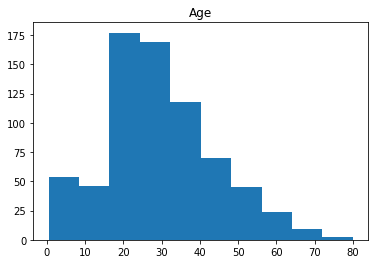

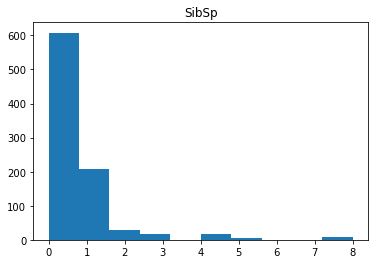

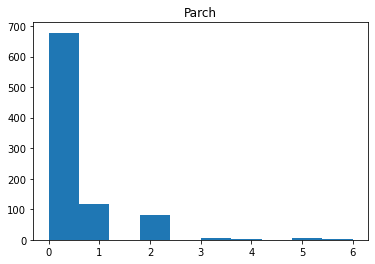

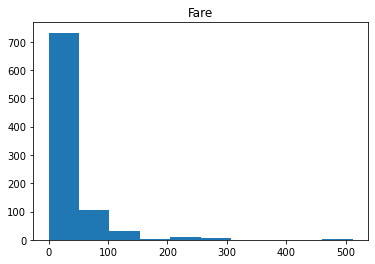

In [149]:
#histogram plot for numerical features
for i in train_data_num.columns:
    plt.hist(train_data_num[i])
    plt.title(i)
    plt.show()

By looking at the distributions above, we see that it is better to normalize them before working with the data.

In [150]:
#let's check the relationship between Survived and numerical features
pd.pivot_table(train_data,index='Survived',values=train_data_num.columns)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


The pivot table tells us that on average, the likeliness of survival was higher for those who were younger in age, paid a higher fare, had a parent/child on a ship with them, and didn't have a sibling/spouse with them.

In [151]:
#let's check the relationship between Survived and categorical features
print(pd.pivot_table(train_data,index='Survived',columns='Pclass',values='Ticket',aggfunc='count'))
print(pd.pivot_table(train_data,index='Survived',columns='Sex',values='Ticket',aggfunc='count'))
print(pd.pivot_table(train_data,index='Survived',columns='Embarked',values='Ticket',aggfunc='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Sex       female  male
Survived              
0             81   468
1            233   109
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


The Pclass pivot table tells us that survivability based on ticket class was the highest for 1st class and the lowest for 3rd class and the differences in survivability based on class is very drastic.

The Sex pivot table tells us that survivability based on sex was very high for females and very low for males, also with a very drastic difference.

The Embarked pivot table that the survivability based on the port embarked from is higher for port C, lower for port Q, and even lower for port S.

### Handle missing values

In [152]:
combined_data = pd.concat([train_data,test_data],ignore_index=True)

In [153]:
combined_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [154]:
#We are dropping PassengerId because it is a key and not useful data for machine learning
#We are also dropping Cabin because 97% of its values are missing
combined_data.drop(['PassengerId','Cabin'],axis=1,inplace=True)

In [155]:
#The 'Ticket' column is messy and contains both alphabetical and numerical data, so we are dropping it as well
combined_data.drop(['Ticket'],axis=1,inplace=True)

In [156]:
combined_data['Embarked'].fillna(combined_data['Embarked'].mode()[0],inplace=True) # filled categorical feature with mode

In [157]:
combined_data['Fare'].fillna(combined_data['Fare'].median(),inplace=True) # filled continous feature with median
combined_data['Age'].fillna(combined_data['Age'].median(),inplace=True)

## 2. Feature Engineering 

In [158]:
#converting the 'sex' column into ordinal values
combined_data.Sex[combined_data.Sex=="male"] = 0
combined_data.Sex[combined_data.Sex=="female"] = 1
combined_data.Sex = combined_data.Sex.astype(int)

In [159]:
#converting the 'embarked' column into ordinal values
combined_data.Embarked[combined_data.Embarked=="C"] = 0
combined_data.Embarked[combined_data.Embarked=="Q"] = 1
combined_data.Embarked[combined_data.Embarked=="S"] = 2
combined_data.Embarked = combined_data.Embarked.astype(int)

In [160]:
#Combined Parch and SibSp columns because both variables involve family members
combined_data["FamilySize"] = combined_data['Parch'] + combined_data['SibSp']

In [161]:
#Converted the new FamilySize feature's values into ordinal values
combined_data.FamilySize[combined_data.FamilySize==1] = 0 
combined_data.FamilySize[(1<combined_data.FamilySize) & (combined_data.FamilySize<5)] = 1 
combined_data.FamilySize[combined_data.FamilySize>=5] = 2 #large family
combined_data.FamilySize = combined_data.FamilySize.astype(int)
combined_data.Parch = combined_data.Parch.astype(int)
combined_data.SibSp = combined_data.SibSp.astype(int)

In [162]:
#Converting the titles of various passengers into ordinal values based on each title's ranking in status
combined_data["Titles"]= combined_data['Name'].str.extract('([A-Za-z]+)\.',expand=False)
combined_data["TitlesBin"] = combined_data.Titles
combined_data.TitlesBin[combined_data.Titles.isin(["Capt","Col","Major","Dr","Rev"])] = 0 #title priority 1
combined_data.TitlesBin[combined_data.Titles.isin(["Jonkheer","Don","Sir","Countess","Dona","Lady"])] = 1 #title priority 2
combined_data.TitlesBin[combined_data.Titles.isin(["Mme","Ms","Mrs",'Mr'])] = 2 #title priority 3
combined_data.TitlesBin[combined_data.Titles.isin(["Mlle","Miss", "Master"])] = 3 #title priority 4
combined_data.TitlesBin = combined_data.TitlesBin.astype(int)

In [163]:
#Dropping columns Name, Titles because we have already extracted the important information from these columns in order to perform modeling
combined_data = combined_data.drop(["Name","Titles"],axis=1)

In [164]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Sex         1309 non-null   int32  
 3   Age         1309 non-null   float64
 4   SibSp       1309 non-null   int32  
 5   Parch       1309 non-null   int32  
 6   Fare        1309 non-null   float64
 7   Embarked    1309 non-null   int32  
 8   FamilySize  1309 non-null   int32  
 9   TitlesBin   1309 non-null   int32  
dtypes: float64(3), int32(6), int64(1)
memory usage: 71.7 KB


In [165]:
#Extracting the numerical and string  columns
integer_columns = list(combined_data.select_dtypes(["int64","int32"]).columns)
string_columns = list(combined_data.select_dtypes(['float64']))

## 3. Two supervised learning algorithms

In [166]:
#Test train split
train= combined_data[combined_data.Survived.isnull()==False]
test= combined_data[combined_data.Survived.isnull()==True]

X = train.drop(["Survived"],axis=1)
Y = train.Survived

X_test = test.drop(["Survived"],axis=1)

In [167]:
#One-Hot Encoding
OHE = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)
OHE_train = pd.DataFrame(OHE.fit_transform(X))
OHE_test = pd.DataFrame(OHE.transform(X_test))

#OHE deletes index so we put it back
OHE_train.index = X.index
OHE_test.index = X_test.index

#Deleting columns with integers
num_X_train = X.drop(integer_columns, axis=1)
num_X_test = X_test.drop(integer_columns, axis=1)

#since ohe is not that efficient when it comes to float columns so we added them seperately 
x_train = pd.concat([num_X_train, OHE_train], axis=1)
x_test = pd.concat([num_X_test, OHE_test], axis=1)

#Encoding our Y
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

In [168]:
#OHE.categories_

In [169]:
#Creating validation set
x_tr, x_t, y_tr, y_t = train_test_split(x_train, Y, test_size=0.33,random_state=7)

### Random Forest Classifier 

In [170]:
from sklearn.ensemble import RandomForestClassifier
modelrf = RandomForestClassifier(random_state=1, max_depth=5)
pred_rf = modelrf.fit(x_tr,y_tr).predict(x_t)
print(classification_report(pred_rf,y_t))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       198
           1       0.61      0.75      0.68        97

    accuracy                           0.76       295
   macro avg       0.74      0.76      0.74       295
weighted avg       0.78      0.76      0.77       295



### SVM 

In [171]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(x_tr, y_tr)
y_pred = clf.predict(x_t)
print(classification_report(y_pred,y_t))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       188
           1       0.67      0.75      0.71       107

    accuracy                           0.78       295
   macro avg       0.76      0.77      0.76       295
weighted avg       0.78      0.78      0.78       295



Since the accuracy and f1-score for the svm are both higher than for the random forest classifier, we will do the hyperparameter tuning for SVM

In [172]:
pipe_steps = [[('scaler_rbf', StandardScaler()), ('SVM_rbf', svm.SVC())],
              [('scaler_poly', StandardScaler()), ('SVM_poly', svm.SVC(kernel='poly'))],
             [('scaler_lin', StandardScaler()), ('SVM_lin', svm.SVC(kernel='linear'))]]
check_params = [{'SVM_rbf__C': [0.1, 1, 10, 100, 1000],  'SVM_rbf__gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
    {'SVM_poly__C': [0.1, 1, 10, 100, 1000],  'SVM_poly__degree': [2, 3, 4]},
    {'SVM_lin__C': [0.1, 1, 10, 100]}]
for i,j in zip(pipe_steps, check_params):
    pipeline = Pipeline(i)
    gridsearch = GridSearchCV(pipeline, j, cv=3, n_jobs=-1, scoring='accuracy')
    gridsearch.fit(x_tr,y_tr)
    print('GridSearch best parameters: ', gridsearch.best_params_)

GridSearch best parameters:  {'SVM_rbf__C': 10, 'SVM_rbf__gamma': 0.0001}
GridSearch best parameters:  {'SVM_poly__C': 1000, 'SVM_poly__degree': 3}
GridSearch best parameters:  {'SVM_lin__C': 0.1}


In [173]:
#Predictions
rbf_pred = grid_rbf.predict(x_t)
linear_pred = grid_lin.predict(x_t)
poly_pred = grid_poly.predict(x_t)

### Model Evaluation 

In [174]:
#Classification reports
cm_lin = confusion_matrix(y_t, linear_pred)
cm_poly = confusion_matrix(y_t,poly_pred)
cm_rbf = confusion_matrix(y_t,rbf_pred)

print(classification_report(y_t,linear_pred))
print(classification_report(y_t,poly_pred))
print(classification_report(y_t,rbf_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       176
           1       0.74      0.66      0.69       119

    accuracy                           0.77       295
   macro avg       0.76      0.75      0.75       295
weighted avg       0.76      0.77      0.76       295

              precision    recall  f1-score   support

           0       0.68      0.89      0.77       176
           1       0.69      0.37      0.48       119

    accuracy                           0.68       295
   macro avg       0.68      0.63      0.62       295
weighted avg       0.68      0.68      0.65       295

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       176
           1       0.78      0.61      0.69       119

    accuracy                           0.77       295
   macro avg       0.77      0.75      0.75       295
weighted avg       0.77      0.77      0.77       295



The accuracy for linear and rbf kernel is equivalent but the f1-score for rbf is higher, so we will use rbf.

<AxesSubplot:>

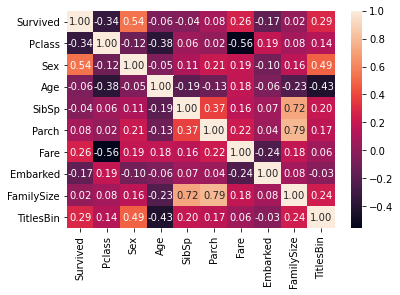

In [180]:
#Correlation Table
cm = combined_data.corr()
#mask = np.triu(np.ones_like(cm, dtype=np.bool))

#f, ax = plt.subplots(figsize=(12, 9))
#g1 = sns.heatmap(cm,cmap='mako_r',fmt='.2f', annot=True, mask=mask)
#g1.set_xticklabels(g1.get_xticklabels(),rotation=70,fontsize=10)
#g1.set_yticklabels(g1.get_yticklabels(),rotation=15,fontsize=10)
#plt.show()
sns.heatmap(cm,fmt='.2f', annot=True)

we dropped the columns in which the absolute value of correlation is less than 0.2

In [181]:
train_df2 = combined_data.drop(['Age','SibSp','Parch','Embarked','FamilySize'], axis=1)

In [182]:
#Extracting integer columns
integer_columns2 = list(train_df2.select_dtypes(['int64','int32']).columns)
string_columns2 = list(train_df2.select_dtypes(['float64']))

In [183]:
#Test train split after feature selection
train2= train_df2[train_df2.Survived.isnull()==False]
test2= train_df2[train_df2.Survived.isnull()==True]

X2 = train2.drop(["Survived"],axis=1)
Y2 = train2.Survived

X_test2 = test2.drop(["Survived"],axis=1)

In [184]:
#One-Hot Encoding once again
OHE2 = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)

OHE_train2 = pd.DataFrame(OHE.fit_transform(X2))
OHE_test2 = pd.DataFrame(OHE.transform(X_test2))

OHE_train2.index = X2.index
OHE_test2.index = X_test2.index

num_X_train2 = X2.drop(integer_columns2, axis=1)
num_X_test2 = X_test2.drop(integer_columns2, axis=1)

#since ohe is not that efficient when it comes to float columns so we added them seperately 
x_train2 = pd.concat([num_X_train2, OHE_train2], axis=1)
x_test2 = pd.concat([num_X_test2, OHE_test2], axis=1)

le2 = preprocessing.LabelEncoder()
Y2 = le.fit_transform(Y)

In [185]:
#Validation set
x_tr2, x_t2, y_tr2, y_t2 = train_test_split(x_train2, Y2, test_size=0.33,random_state=7)

In [186]:
#KERNEL = RBF ##
pipe_steps_rbf2 = [('scaler_rbf2', StandardScaler()), ('SVM_rbf2', svm.SVC())]

check_params_rbf2= {
    'SVM_rbf2__C': [0.1, 1, 10, 100, 1000],  
    'SVM_rbf2__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

pipeline_rbf2 = Pipeline(pipe_steps_rbf2)
grid_rbf2 = GridSearchCV(pipeline_rbf2, check_params_rbf2, cv=3, n_jobs=-1, scoring='accuracy')
grid_rbf2.fit(x_tr2,y_tr2)

print("Grid search best params: ", grid_rbf2.best_params_)

Grid search best params:  {'SVM_rbf2__C': 1000, 'SVM_rbf2__gamma': 0.001}


In [187]:
#Prediction with feature selection
rbf_pred2 = grid_rbf2.predict(x_t2)

### Model Evaluation 

In [188]:
print(classification_report(y_t,rbf_pred))
print(classification_report(y_t2,rbf_pred2))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       176
           1       0.78      0.61      0.69       119

    accuracy                           0.77       295
   macro avg       0.77      0.75      0.75       295
weighted avg       0.77      0.77      0.77       295

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       176
           1       0.80      0.69      0.74       119

    accuracy                           0.80       295
   macro avg       0.80      0.78      0.79       295
weighted avg       0.80      0.80      0.80       295



In [189]:
#Best model
svm_final = svm.SVC(kernel='rbf', C=1000, gamma=0.001)

In [190]:
#Fitting
svm_final.fit(x_train2, Y2)

SVC(C=1000, gamma=0.001)

In [191]:
predicted_svm = svm_final.predict(x_test2)

In [192]:
submission = pd.DataFrame({ 'PassengerId': test_data.PassengerId,
                            'Survived': predicted_svm })
submission.to_csv("submission_svc.csv", index=False)

## 4. Advanced Model - XGBoost

Now we will try using an advanced model to see if we can improve the score

In [193]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [194]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [195]:
grid_xgb = GridSearchCV(xgb, params, cv=3, n_jobs=4, scoring='accuracy',verbose=3)
grid_xgb.fit(x_tr,y_tr)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 14.2min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 20.0min
[Parallel(n_jobs=4)]: Done 1215 out of 1215 | elapsed: 21.5min finished


[19:11:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:11:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     silent=True, subsampl

In [196]:
print("Grid search best params: ", grid_xgb.best_params_)

Grid search best params:  {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}


In [197]:
xgb_pre = grid_xgb.predict(x_t)

In [198]:
# A parameter grid for XGBoost
params2 = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb2 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

grid_xgb2 = GridSearchCV(xgb2, params2, cv=3, n_jobs=4, scoring='accuracy',verbose=3)
grid_xgb2.fit(x_tr2,y_tr2)

print("Grid search best params: ", grid_xgb2.best_params_)

xgb_pre2 = grid_xgb2.predict(x_t2)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 13.5min
[Parallel(n_jobs=4)]: Done 1215 out of 1215 | elapsed: 14.5min finished


[19:26:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:26:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Grid search best params:  {'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 1.0}


In [199]:
print(classification_report(y_t,xgb_pre))
print(classification_report(y_t2,xgb_pre2))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       176
           1       0.81      0.66      0.73       119

    accuracy                           0.80       295
   macro avg       0.80      0.78      0.78       295
weighted avg       0.80      0.80      0.80       295

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       176
           1       0.83      0.65      0.73       119

    accuracy                           0.80       295
   macro avg       0.81      0.78      0.79       295
weighted avg       0.81      0.80      0.80       295



In [200]:
xgbm = XGBClassifier(colsample_bytree = 1.0, gamma = 1, max_depth = 4, min_child_weight = 5, subsample = 1.0)
xgbm.fit(x_train2,Y2)
predicted_xgb = xgbm.predict(x_test2)

[19:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [201]:
submission = pd.DataFrame({ 'PassengerId': test_data.PassengerId,
                            'Survived': predicted_xgb })
submission.to_csv("submission_xgb.csv", index=False)